In [1]:
cd d:

D:\


In [2]:
cd d:/workspace/dengAI/

d:\workspace\dengAI


In [3]:
%run -i loadData.py

In [4]:
data1 = dataCity1.values
data1[:,[24,25]] = data1[:,[25,24]]  #swap collumns, such that number of cases is last collumn

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
%matplotlib notebook

In [7]:
scalar = MinMaxScaler()
data1b = scalar.fit_transform(data1)
scaleY = np.max(data1[:,-1])
offY = np.min(data1[:,-1])
data1b[:,-1] = scaleY * data1b[:,-1] + offY

In [8]:
# convert data into following format:
# dataX = all features of the previous 52 days (including number of cases), i.e. 52*26 entries 
# dataY = number of cases nForecast days in the future
def convert(dataIn, nLookBack, nForecast):
    data2x = []
    data2y = []
    for ind in range(dataIn.shape[0]-nLookBack-nForecast):
        sub = dataIn[ind:ind+nLookBack,:]
        sub2 = sub.flatten()
        data2x.append(sub2)
        sub = dataIn[ind + nLookBack + nForecast-1,-1]
        data2y.append(sub)
    dataX = np.stack(data2x)
    dataY = np.stack(data2y)
    dataY = np.reshape(dataY,(dataY.shape[0],1))
    return (dataX,dataY)

In [9]:
nForecast = 4  #how many days ahead should be predicted
dataX, dataY = convert(data1b,52,nForecast)
trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.158, random_state=1)
testY.shape #model requires test set to be of size 128

(128, 1)

In [10]:
# reduce the input data vector (52weeks *26 features) to nInput nodes selected by highest correlation with the target feature
C = np.zeros(dataX.shape[1])
for indx in range(dataX.shape[1]):
    vx = dataX[:,indx]
    for indy in range(dataY.shape[1]):
        vy = dataY[:,indy]
        tmp = np.corrcoef(vx,vy)
        C[indx] += np.abs(tmp[0,1] )  
C[np.isnan(C)] = -1
candidates = np.flip(np.argsort(C),axis=0)
def limitX(dataX,candidates, N):
    out = []
    for row in range(dataX.shape[0]):
        tmp = dataX[row,:]
        out.append(tmp[candidates[0:N]])
    return np.stack(out)

C:\Users\dominik\.conda\envs\py35\lib\site-packages\numpy\lib\function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\dominik\.conda\envs\py35\lib\site-packages\numpy\lib\function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [11]:
import NN_1Dense

In [12]:
def coarseGridScan(dataSets):
    (trainX, trainY, testX, testY) = dataSets
    bestResult = None
    bestCost = None
    iteration = -1
    for p1 in np.arange(3.2,7.4,0.2):
        nInput = np.int32(np.exp(p1))
        for nHidden in range(10,3*nInput,int(0.4*nInput)):
            iteration += 1
            nTarget = 1
            w01 = np.random.rand(nInput, nHidden).astype(np.float32) / (4* np.sqrt(nInput)) 
            w12 = np.random.rand(nHidden, nTarget).astype(np.float32) / (4* np.sqrt(nHidden))*scaleY
            testX2 = limitX(testX,candidates, nInput)
            trainX2 = limitX(trainX,candidates, nInput)
            (cost, bestW01, bestW12, bestB01,bestB12) = NN_1Dense.optimizeModel((trainX2,testX2,trainY,testY), nHidden, (w01,w12))
            if bestResult == None or cost < bestCost:
                bestCost = cost
                bestResult = (cost, bestW01, bestW12, bestB01,bestB12)
            print("# %d : %d, %d --> %f" % (iteration, nInput, nHidden, cost))
    return bestResult

In [13]:
def fineGridScan(dataSets, bestNInput, bestNHidden):
    (trainX, trainY, testX, testY) = dataSets
    bestResult = None
    bestCost = None
    iteration = -1
    for nInput in np.unique(np.int32(np.arange(0.9,1.11,0.05)*bestNInput)):
        if nInput < 1 or nInput > 52 * 26:
            continue
        for nHidden in np.unique(np.int32(np.arange(0.9,1.11,0.05)*bestNHidden)):
            if nHidden < 1:
                continue
            iteration += 1
            nTarget = 1
            w01 = np.random.rand(nInput, nHidden).astype(np.float32) / (4* np.sqrt(nInput)) 
            w12 = np.random.rand(nHidden, nTarget).astype(np.float32) / (4* np.sqrt(nHidden))*scaleY
            testX2 = limitX(testX,candidates, nInput)
            trainX2 = limitX(trainX,candidates, nInput)
            (cost, bestW01, bestW12, bestB01,bestB12) = NN_1Dense.optimizeModel((trainX2,testX2,trainY,testY), nHidden, (w01,w12))
            if bestResult == None or cost < bestCost:
                bestCost = cost
                bestResult = (cost, bestW01, bestW12, bestB01,bestB12)
            print("# %d : %d, %d --> %f" % (iteration, nInput, nHidden, cost))
    return bestResult

In [ ]:
dataSets = (trainX, trainY, testX, testY)
bestResult = coarseGridScan(dataSets)

In [15]:
from copy import copy
(bestCost, bestW01, bestW12, bestB01, bestB12) = bestResult
print(bestCost)
bestNInput = bestW01.shape[0]
bestNHidden = bestW01.shape[1]
resultCoarse = copy(bestResult)
result = fineGridScan(dataSets, bestNInput, bestNHidden)
if resultCoarse[0] < result[0]:
    bestResult = resultCoarse
else:
    bestResult = result

364.195
# 0 : 1205, 490 --> 398.357941
# 1 : 1205, 517 --> 391.096039
# 2 : 1205, 545 --> 384.789276
# 3 : 1205, 572 --> 415.365967
# 4 : 1205, 599 --> 404.059814
# 5 : 1272, 490 --> 340.103088
# 6 : 1272, 517 --> 367.783875
# 7 : 1272, 545 --> 361.039978
# 8 : 1272, 572 --> 362.900146
# 9 : 1272, 599 --> 364.265747
# 10 : 1339, 490 --> 349.806244
# 11 : 1339, 517 --> 357.941772
# 12 : 1339, 545 --> 350.810730
# 13 : 1339, 572 --> 358.087677
# 14 : 1339, 599 --> 342.934540


In [16]:
(bestCost, bestW01, bestW12, bestB01, bestB12) = bestResult
print(bestCost)
print(bestW01.shape)

340.103
(1272, 490)


In [17]:
# make predictions
nInput = bestW01.shape[0]
nHidden = bestW12.shape[0]
nTarget = 1
import tensorflow as tf
weights01 = tf.Variable(bestW01)
weights12 = tf.Variable(bestW12)
biases01 = tf.Variable(bestB01)
biases12 = tf.Variable(bestB12)
xPlaceholder = tf.placeholder(tf.float32, [dataX.shape[0], nInput])
yPlaceholder = tf.placeholder(tf.float32, [dataX.shape[0], nTarget])

def predictionFunction(x, w01, w12, b01, b12):
    result1 = tf.nn.tanh(tf.matmul(x, w01) + b01)
    result2 = tf.nn.relu(tf.matmul(result1, w12) + b12)
    return result2

data2 = limitX(dataX,candidates,nInput)
with tf.Session() as sess:
    predExpression = predictionFunction(xPlaceholder, bestW01, bestW12, bestB01, bestB12)
    pred = sess.run(predExpression, {xPlaceholder : data2})

<IPython.core.display.Javascript object>


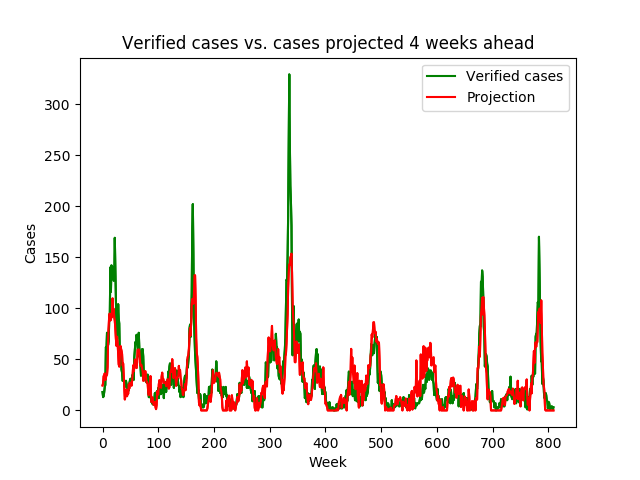

In [18]:
g1, = plt.plot(dataY,'g')
g2, = plt.plot(pred,'r')
plt.xlabel("Week")
plt.ylabel("Cases")
plt.title("Verified cases vs. cases projected %d weeks ahead" % nForecast)
plt.legend([g1,g2],['Verified cases', 'Projection'])

In [19]:
np.sqrt(bestCost) # mean square error for each time step

18.441885

<IPython.core.display.Javascript object>


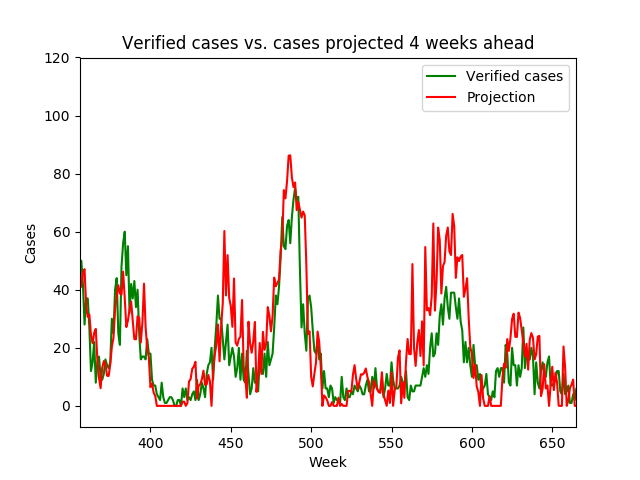

In [21]:
g1, = plt.plot(dataY,'g')
g2, = plt.plot(pred,'r')
plt.xlabel("Week")
plt.ylabel("Cases")
plt.title("Verified cases vs. cases projected %d weeks ahead" % nForecast)
plt.legend([g1,g2],['Verified cases', 'Projection'])